# Importing dependencies

In [609]:
import os
import pathlib
import getpass
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks


from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                             confusion_matrix, 
                             roc_curve, 
                             auc, 
                             roc_auc_score, 
                             precision_score, 
                             f1_score)


import warnings
warnings.filterwarnings('always')

# Data Exploration

In [612]:
def load_scale(dir_path, flag='BGR', image_size=225, scaler=255):
    """
    Parameters:
    dir_path (str): The absolute path to the directory containing all the dataset classes.
    flag (str): Specifies which color channels to use for storing the image; accepted values are 'BGR', 'RGB', or 'GRAY'..
    
    Returns:
    tuple: A tuple containing two elements. The first is a list of classes names, and the second is a dictionary where the keys are class indices
    from the classes list and the values are the rescaled images belonging to each class.
    """
    classes = [x for x in os.listdir(dir_path) if not x.startswith('.')]
    data = {}
    image_list = []
    class_list = []
    for group in classes:
        group_path = os.path.join(dir_path, group)
        for image_str in os.listdir(group_path):
            image_path = os.path.join(group_path, image_str)
            try:
                image = cv2.imread(image_path)
                if flag == 'BGR':
                    pass
                elif flag == 'RGB':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                elif flag == 'GRAY':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)                    
            except:
                pass
            image = cv2.resize(image, (image_size,image_size))
            image = image/scaler
            image_list.append(image)
            class_list.append(classes.index(group))
        data['images'] = image_list
        data['class'] = class_list        
    return classes, data

In [613]:
parent_path = pathlib.Path(getpass.getpass())
train_path = parent_path/'train'
test_path = parent_path/'test'
val_path = parent_path/'val'

 ········


In [614]:
train_data = load_scale(train_path, flag='GRAY')
test_data = load_scale(test_path, flag='GRAY')
val_data = load_scale(val_path, flag='GRAY')

In [770]:
def classes_visualize(data, x_label):
    sns.set_style('darkgrid')
    g = sns.countplot(x=data[1]['class'], hue=data[1]['class'])
    
    g.bar_label(g.containers[0], fmt="{:.0f} cases")
    g.bar_label(g.containers[1], fmt="{:.0f} cases")
    g.set_xticks(list(range(len(data[0]))))
    g.set_xticklabels(data[0])
    plt.title(x_label.title())
    plt.xlabel("Diagnosis")
    plt.ylabel("Cases", rotation=0)
    g.yaxis.get_label().set_ha("right")
    plt.legend(data[0], frameon=False, bbox_to_anchor=(1.3, 1.))
    plt.show()

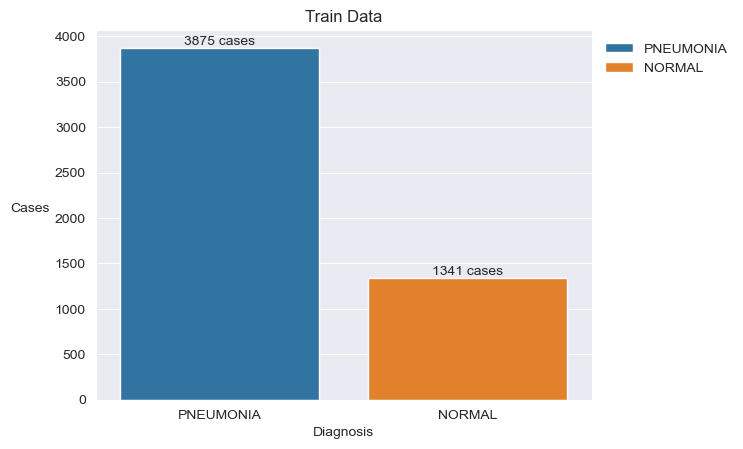

In [771]:
classes_visualize(train_data, 'train data')

- Class imbalance detected, favoring the positive class.

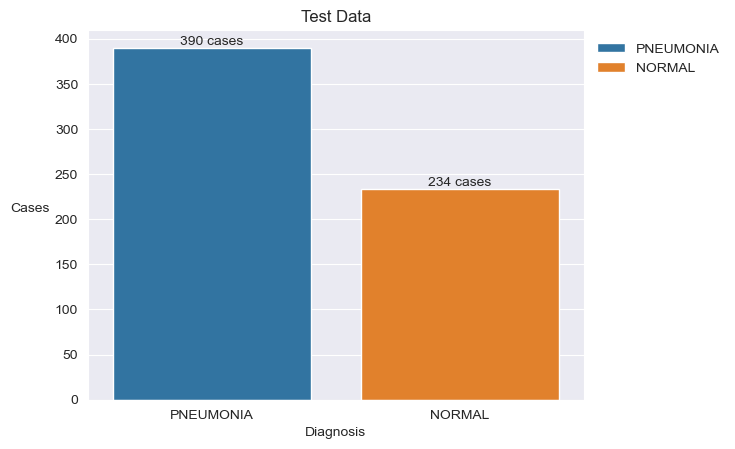

In [772]:
classes_visualize(test_data, 'test data')

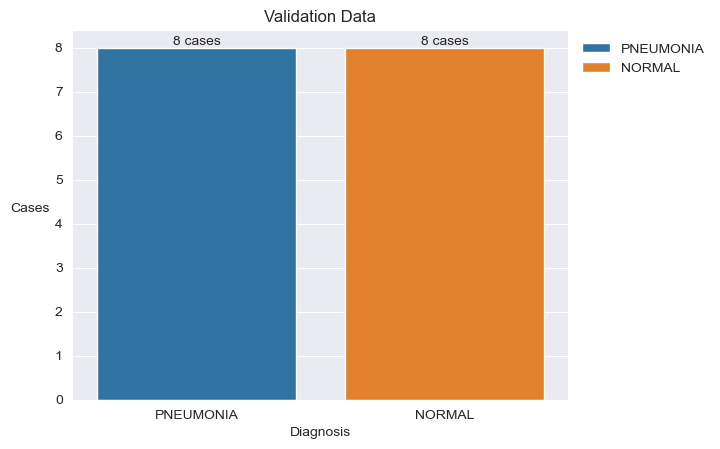

In [773]:
classes_visualize(val_data, 'validation data')

- There is class impalance in the train data that will be addressed using augmentation layers in the model.

In [878]:
def object_visual(data):
    for i in range(4):
        plt.figure(figsize=(15,80))
        for group in data[0]:
            cat = data[0].index(group)
            index = np.random.choice(np.where(np.array(data[1]['class'])==cat)[0])
            plt.subplot(4, 2, i*2+cat+1)
            plt.imshow(data[1]['images'][index], 'gray')
            plt.title(group)
            plt.grid(False)
            plt.tick_params("both", length=0)
            plt.xticks([],[])
            plt.yticks([],[])
    plt.tight_layout()
    plt.show()


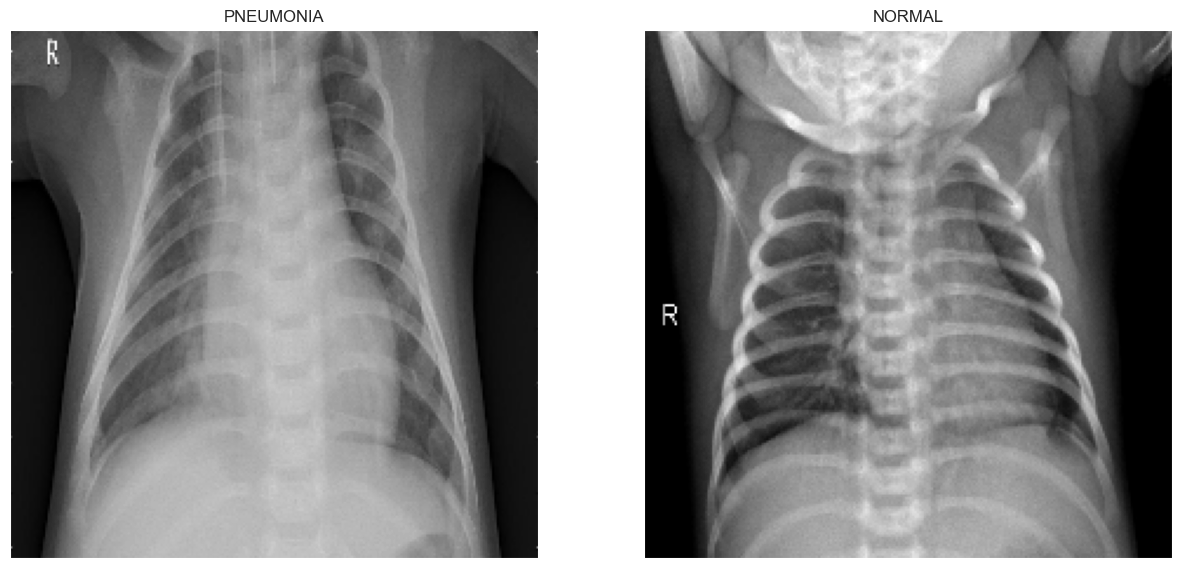

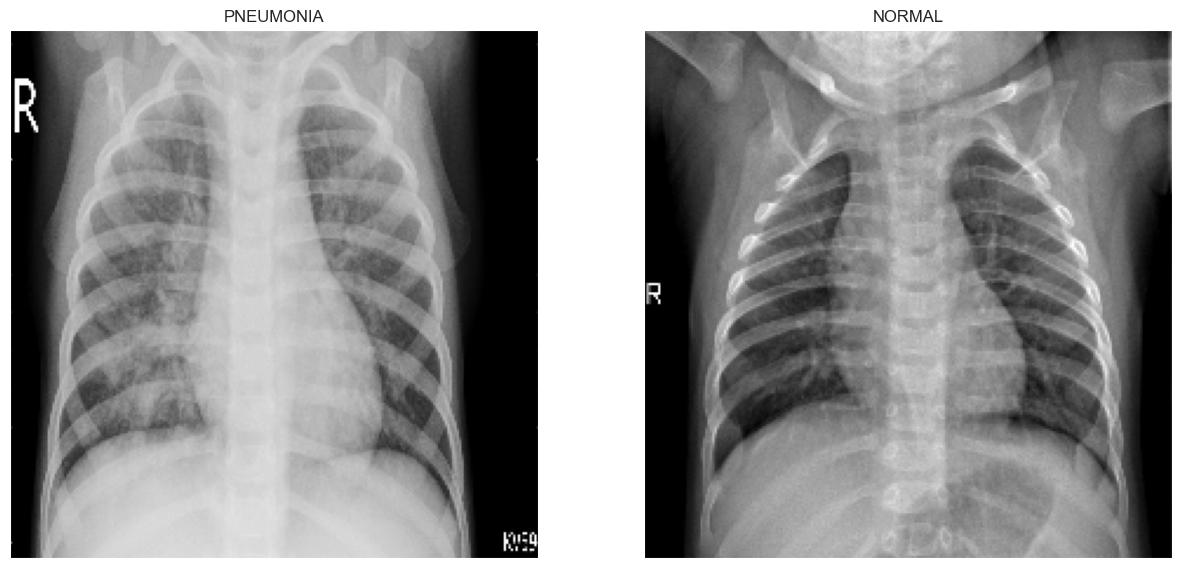

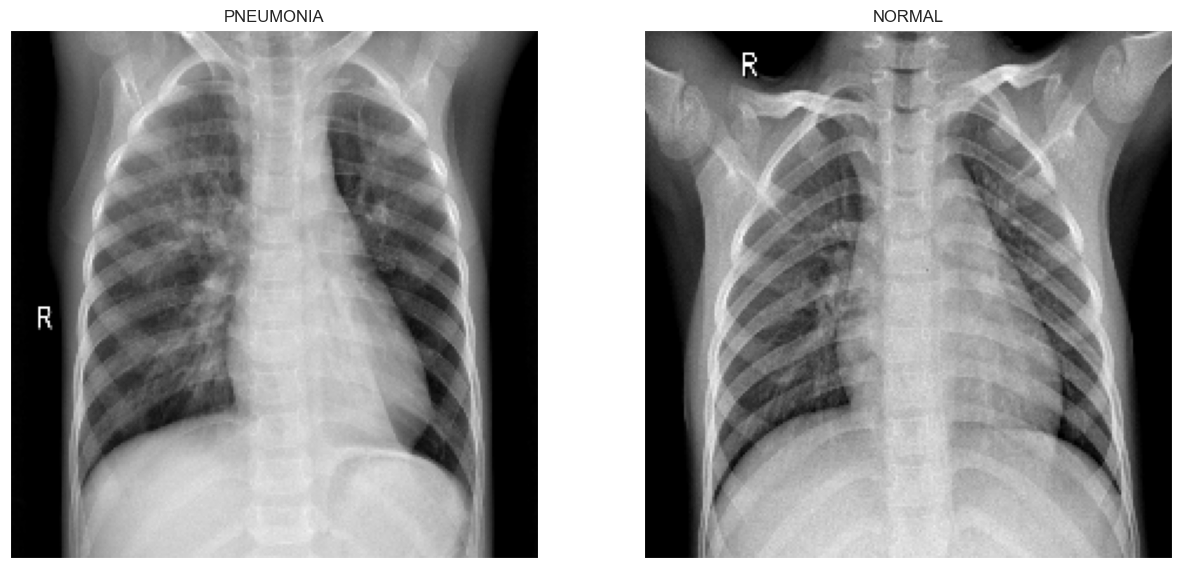

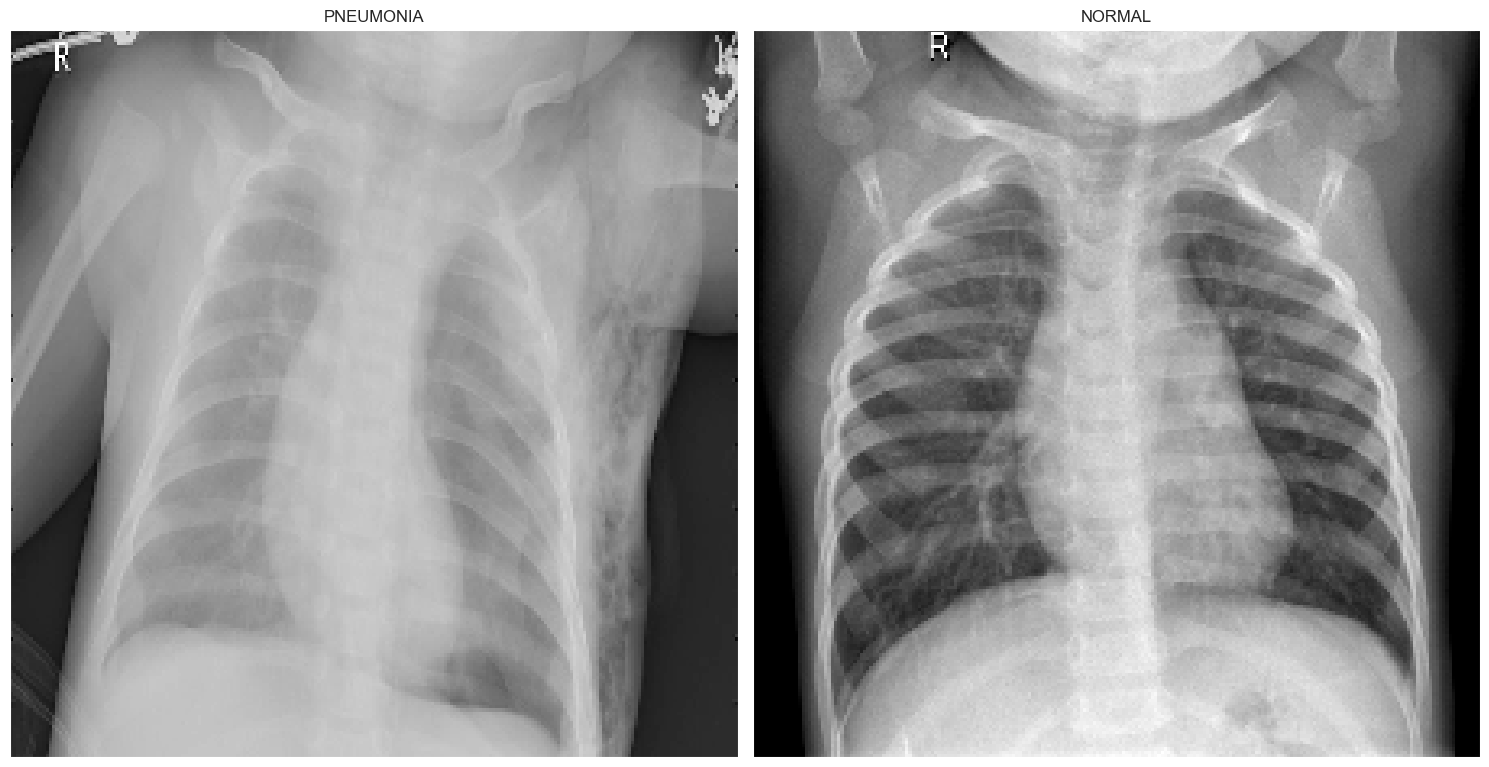

In [879]:
object_visual(train_data)

- The data seems imbalanced . To increase the no. of training examples, we will use data augmentation.

# Data preprocessing

1. create a tf.data.Dataset objects for training, testing and validation.

In [794]:
BATCH_SIZE = 32 
IMG_SIZE = (150,150) #resizing

def data_loader_from_directory(path):
    data_loader = tf.keras.utils.image_dataset_from_directory(path,
                                                              shuffle=True,
                                                              batch_size=BATCH_SIZE,                    
                                                              image_size=IMG_SIZE,
                                                              label_mode='binary',
                                                              color_mode='grayscale')
    return data_loader

In [795]:
train_dataset = data_loader_from_directory(train_path)
test_dataset  = data_loader_from_directory(test_path)
val_dataset   = data_loader_from_directory(val_path)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


- Classes in chest X-ray dataset

In [623]:
class_names = train_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


- Previewing sample of images for both classes

2024-10-02 08:41:58.174637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


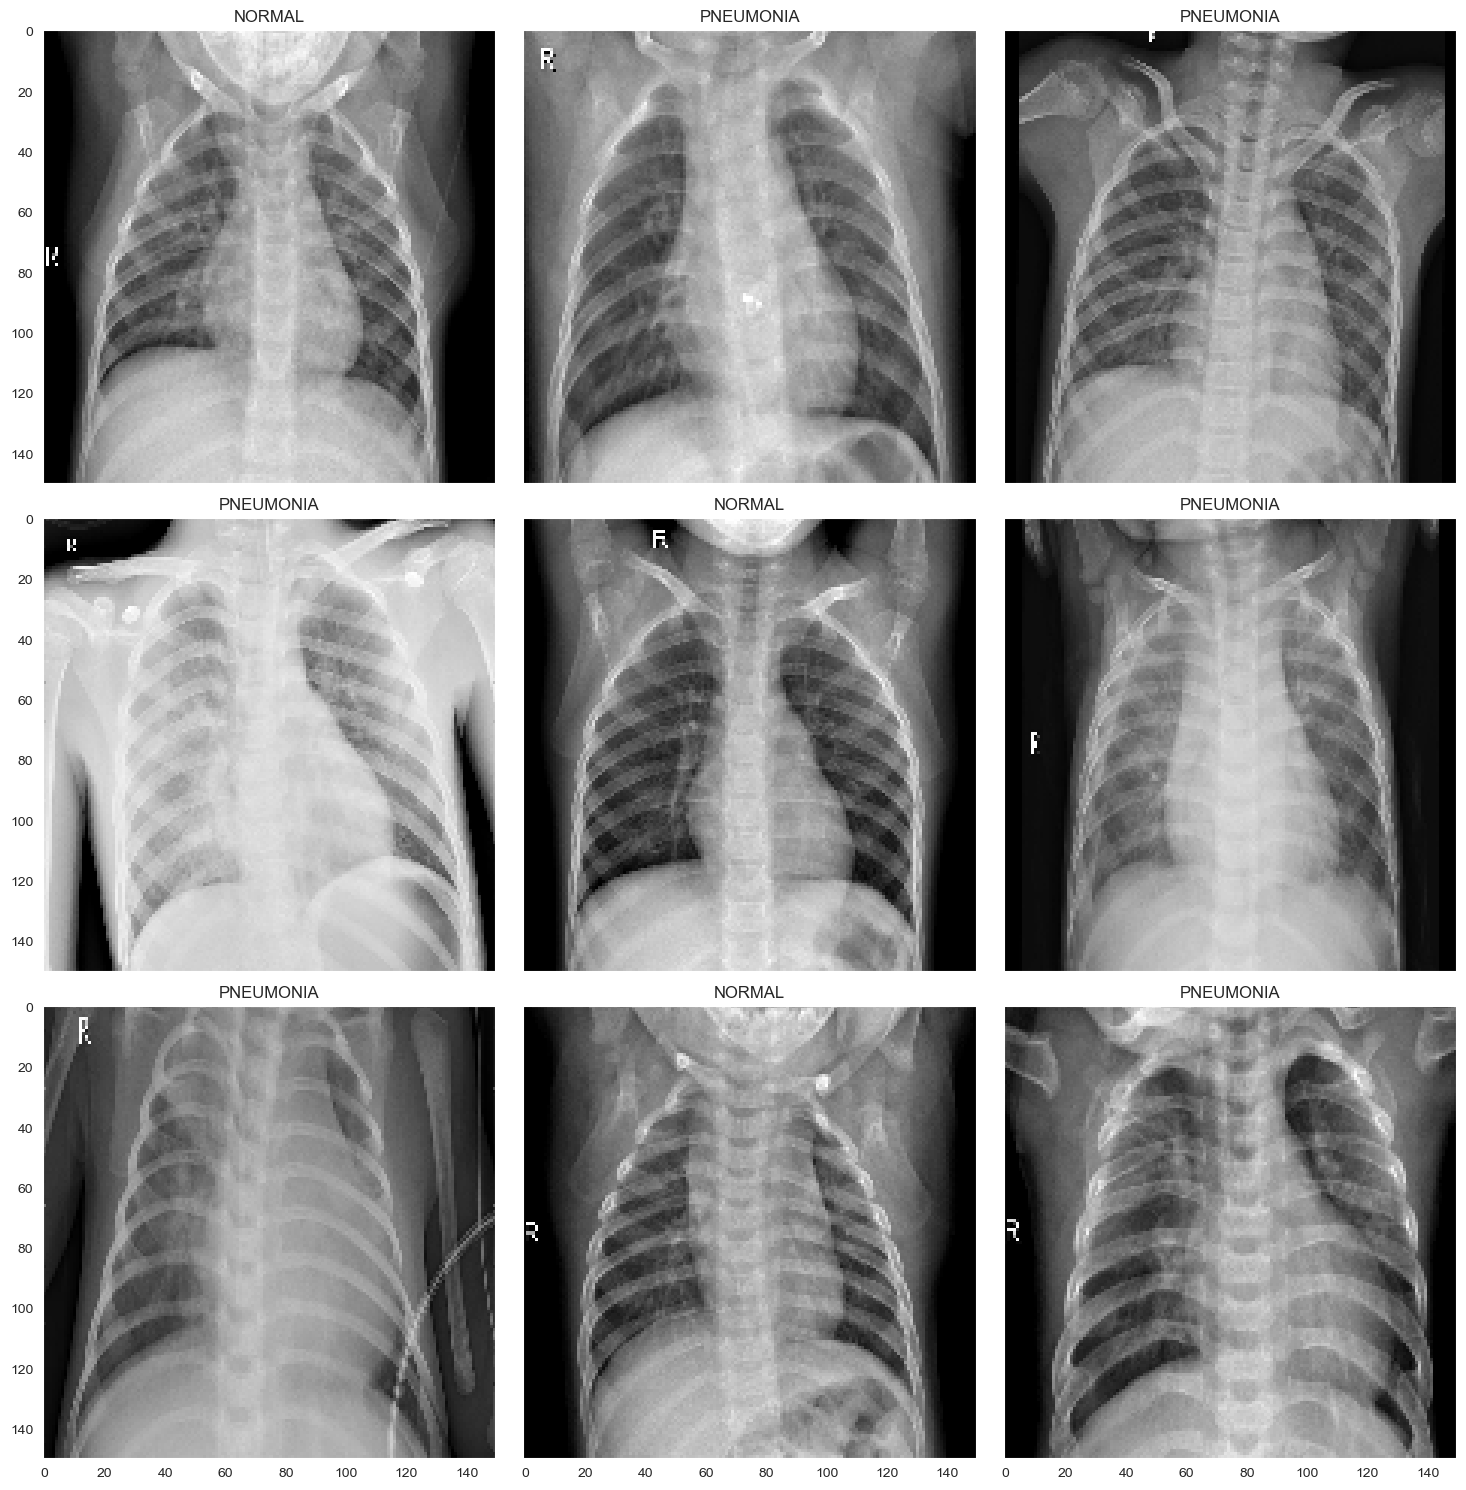

In [818]:
plt.figure(figsize=(15,15))
for imgs, labels in train_dataset.take(1):
    for i in range(9):
        img = imgs[i].numpy()
        label = labels[i]
        plt.subplot(3,3,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_names[label.numpy()[0].astype(int)])
        
        if i%3!=0:
            plt.yticks([], [])
            plt.tick_params("y", length=0)
        if 9-i>3:
            plt.xticks([], [])
            plt.tick_params("x", length=0)
        plt.grid(False)
        
        # plt.axis('off')
        plt.tight_layout()
plt.show()

## Configure the dataset for performance

**Use buffered prefetching to load images from disk without having I/O become blocking.**
- The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
- We could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will prompt the `tf.data` runtime to tune the value dynamically at runtime.

In [396]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Resizing & Rescaling

In [397]:
resize_layer = tf.keras.Sequential([tf.keras.layers.Resizing(150,150),
                                   tf.keras.layers.Rescaling(1/255),
                                   ])

# Data Augmentation

In [398]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomCrop(int(150*.95), int(150*.95)),
    tf.keras.layers.RandomZoom(0.1)
])
                                         

### Previewing sample of preprocessed images.

2024-10-02 08:46:03.142780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


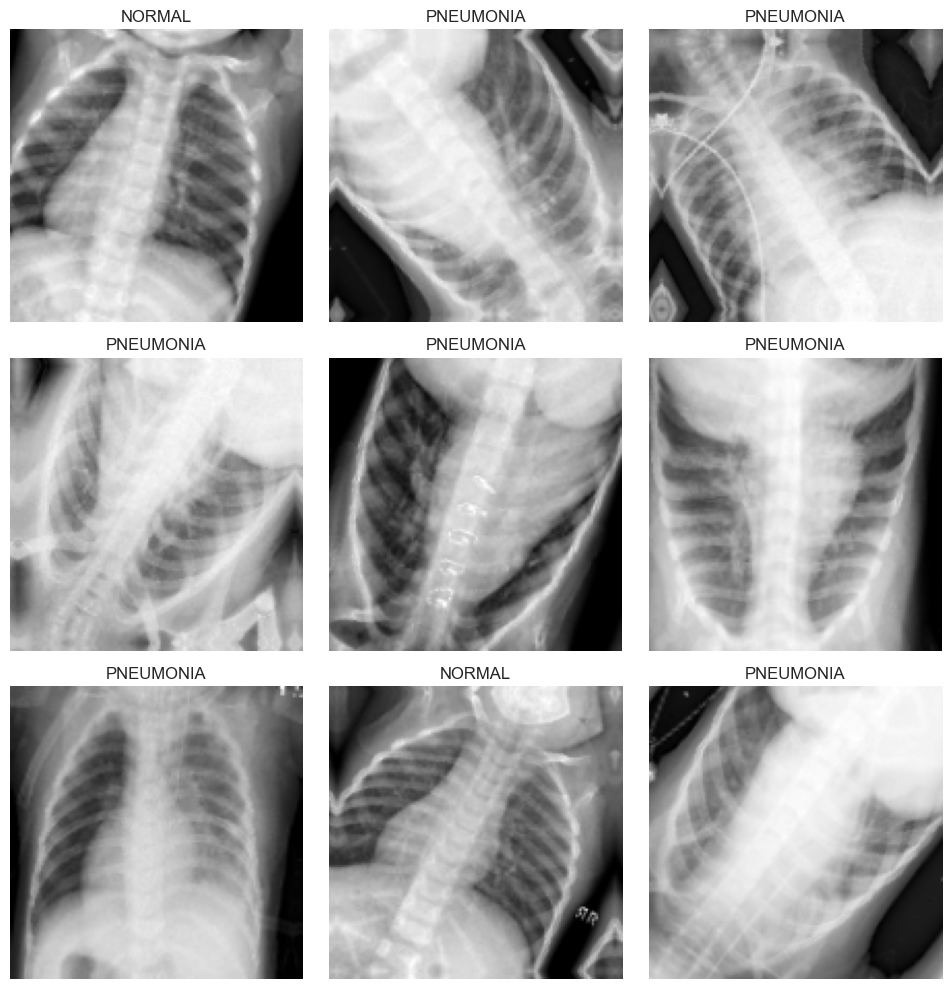

In [821]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):

    augmented_images = resize_layer(images)
    augmented_images = data_augmentation(augmented_images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i], cmap='gray')
        plt.title(class_names[labels[i].numpy().astype('uint8')[0]])        
        plt.axis("off")
        plt.tight_layout()

# Model Building and training

In [410]:
model = Sequential()
model.add(resize_layer)
model.add(data_augmentation)
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "Adam" , loss = 'binary_crossentropy' , metrics = ['accuracy', 'recall', 'precision'])
model.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_68 (Sequential)      │ (32, 150, 150, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_69 (Sequential)      │ (32, 142, 142, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (32, 142, 142, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (32, 142, 142, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (32, 71, 71, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (32, 71, 71, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (32, 71, 71, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (32, 71, 71, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (32, 36, 36, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (32, 36, 36, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (32, 36, 36, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (32, 18, 18, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (32, 18, 18, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (32, 18, 18, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (32, 18, 18, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (32, 9, 9, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (32, 9, 9, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (32, 9, 9, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (32, 9, 9, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (32, 5, 5, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (32, 5, 5, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (32, 5, 5, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,199,233 (8.39 MB)

 Trainable params: 2,197,121 (8.38 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [411]:
initial_epochs = 50

loss0, accuracy0, precision0, recall0 = model.evaluate(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.6929 - precision: 0.0000e+00 - recall: 0.0000e+00


In [412]:
loss0, accuracy0, precision0, recall0

(0.6929311752319336, 0.5, 0.0, 0.0)

In [417]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)

In [418]:
history = model.fit(train_dataset ,epochs = 50 ,
                    validation_data = val_dataset ,callbacks = [learning_rate_reduction, early_stopping])

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 237ms/step - accuracy: 0.8455 - loss: 0.6056 - precision: 0.9011 - recall: 0.8941 - val_accuracy: 0.5000 - val_loss: 14.2707 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.9110 - loss: 0.2130 - precision: 0.9441 - recall: 0.9375 - val_accuracy: 0.5000 - val_loss: 8.3869 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 217ms/step - accuracy: 0.9369 - loss: 0.1696 - precision: 0.9600 - recall: 0.9565 - val_accuracy: 0.5000 - val_loss: 10.4454 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9478 - loss: 0.1408 - precision: 0.9687 - recall: 0.9617
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.9478 - loss: 0.1408 - precis

# Model Evaluation

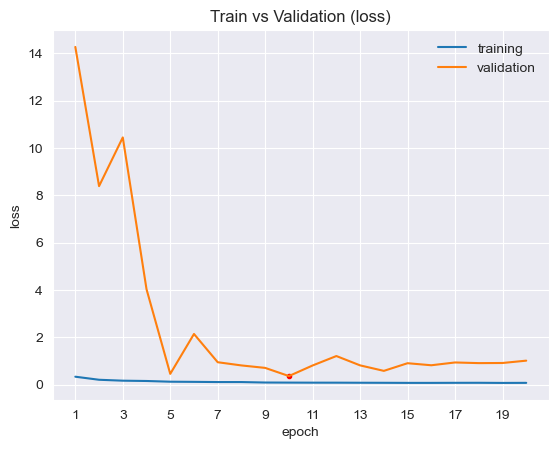

In [893]:
x_axis = range(1, len(history.history["loss"])+1)
selected_epoch=np.argmin(history.history["val_loss"])+1
plt.plot(x_axis, history.history["loss"], label="training")
plt.plot(x_axis, history.history["val_loss"], label="validation")
plt.legend(frameon=False)
plt.title("Train vs Validation (loss)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(x_axis[::2],x_axis[::2])
plt.scatter((selected_epoch,), (history.history["val_loss"][selected_epoch-1],), marker=".", color="red")
plt.show()

- The model shows best performance at epoch number 10.

In [420]:
model.evaluate(train_dataset)

163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9187 - loss: 0.1861 - precision: 0.9969 - recall: 0.8950


[0.1856868863105774,
 0.9194785356521606,
 0.8944516181945801,
 0.9968363642692566]

In [421]:
model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8973 - loss: 0.2667 - precision: 0.8867 - recall: 0.9587


[0.30599668622016907,
 0.8910256624221802,
 0.9461538195610046,
 0.8870192170143127]

In [422]:
model.evaluate(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8125 - loss: 0.3594 - precision: 0.7778 - recall: 0.8750


[0.359391987323761, 0.8125, 0.875, 0.7777777910232544]

- The model exhibits consistent metrics across the training, validation, and testing datasets.

In [423]:
model.save('tuned_model.keras')

In [407]:
loss0, accuracy0, precision0, recall0 = model.evaluate(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5625 - loss: 1.1403 - precision: 0.5333 - recall: 1.0000


In [442]:
datasets = {
    "val_dataset": {"images":[], "labels":[]},
    "train_dataset": {"images":[], "labels":[]},
    "test_dataset": {"images":[], "labels":[]},
}

for dataset, value in datasets.items():
    labels = []
    images = []
    for img, label in globals()[dataset]:
        labels.extend(label.numpy())
        images.extend(img.numpy())
    datasets[dataset]["images"] = np.array(images)
    datasets[dataset]["labels"] = np.array(labels)

2024-10-01 22:44:06.153660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-01 22:44:10.274819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-01 22:44:10.925352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [447]:
for dataset in datasets.values():
    preds = model.predict(dataset["images"])
    dataset["predictions"] = preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [866]:
# Specify satisfactory recall
target_recall = .98

fpr, tpr, thresholds = roc_curve(datasets["test_dataset"]["labels"], 
                                 datasets["test_dataset"]["predictions"], 
                                 pos_label=1)

fpr_train, tpr_train, thresholds_train = roc_curve(datasets["train_dataset"]["labels"], 
                                                   datasets["train_dataset"]["predictions"], 
                                                   pos_label=1)

# Index for the optimal threshold
recall_index = np.where(tpr >= target_recall)[0][0]
best_threshold_test = thresholds[recall_index]
best_fpr_test = fpr[recall_index]
best_tpr_test = tpr[recall_index]
preds_binary = (datasets["test_dataset"]["predictions"] >= best_threshold_test).astype(int)
precision_test = precision_score(datasets["test_dataset"]["labels"], preds_binary)

f1_test = f1_score(datasets["test_dataset"]["labels"], preds_binary)


In [895]:
print(f"Threshold = {best_threshold_test:.2f}")
print(f"False Positive Rate = {best_fpr_test:.2f}")
print(f"True Positive Rate (recall) = {best_tpr_test:.2f}")
print(f"Precision = {precision_test:.2f}")
print(f"F1 Score = {f1_test:.2f}")

Threshold = 0.15
False Positive Rate = 0.38
True Positive Rate (recall) = 0.98
Precision = 0.81
F1 Score = 0.89


In [898]:
print("classification report".center(50))
print("_______________________".center(50))
print()
print("Train".center(50, "-"))
print(classification_report(
    datasets["train_dataset"]["labels"], 
    datasets["train_dataset"]["predictions"]>=best_threshold_test
))
print("".center(50, "="))

print("Test".center(50, "-"))
print(classification_report(
    datasets["test_dataset"]["labels"], 
    datasets["test_dataset"]["predictions"]>=best_threshold_test
))

              classification report               
             _______________________              

----------------------Train-----------------------
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1341
         1.0       0.99      0.97      0.98      3875

    accuracy                           0.97      5216
   macro avg       0.95      0.97      0.96      5216
weighted avg       0.97      0.97      0.97      5216

-----------------------Test-----------------------
              precision    recall  f1-score   support

         0.0       0.95      0.62      0.75       234
         1.0       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624



- Recall is our metric of interest.
- At our selected threshold:
  - Training data recall: 0.97
  - Test data recall: 0.98

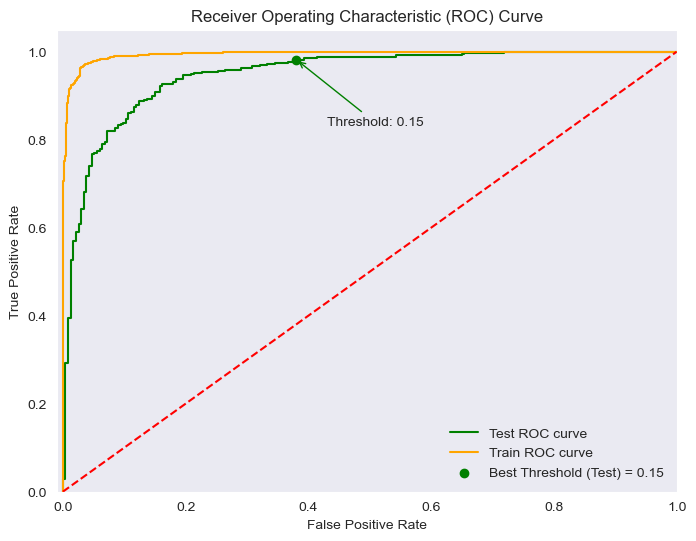

In [899]:
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color="green", label="Test ROC curve")
plt.plot(fpr_train, tpr_train, color="orange", label="Train ROC curve")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.scatter(best_fpr_test, best_tpr_test, color="green", label="Best Threshold (Test) = {:.2f}".format(best_threshold_test), zorder=5)
plt.annotate(f"Threshold: {best_threshold_test:.2f}", xy=(best_fpr_test, best_tpr_test), xytext=(best_fpr_test + 0.05, best_tpr_test - 0.15), arrowprops=dict(arrowstyle="->", color="green"), fontsize=10)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right", frameon=False)
plt.grid()
plt.show()


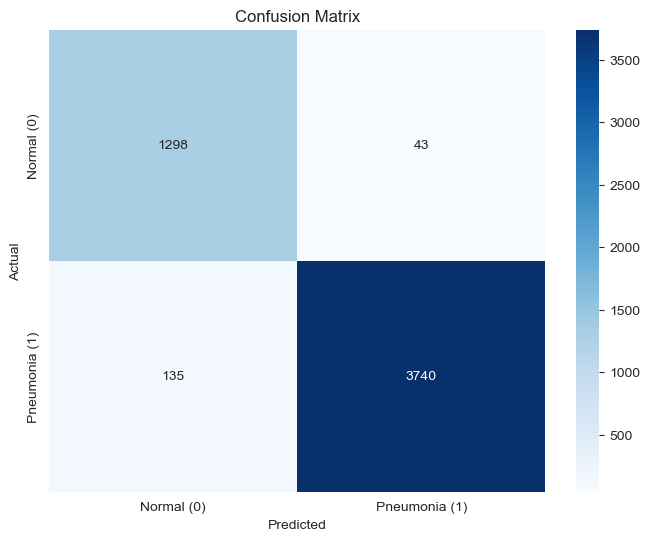

In [852]:
preds_binary = (datasets["train_dataset"]["predictions"] >= best_threshold_test).astype(int)
cm = confusion_matrix(datasets["train_dataset"]["labels"], preds_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal (0)', 'Pneumonia (1)'],
            yticklabels=['Normal (0)', 'Pneumonia (1)'],
            vmax=cm.max(), vmin=cm.min())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

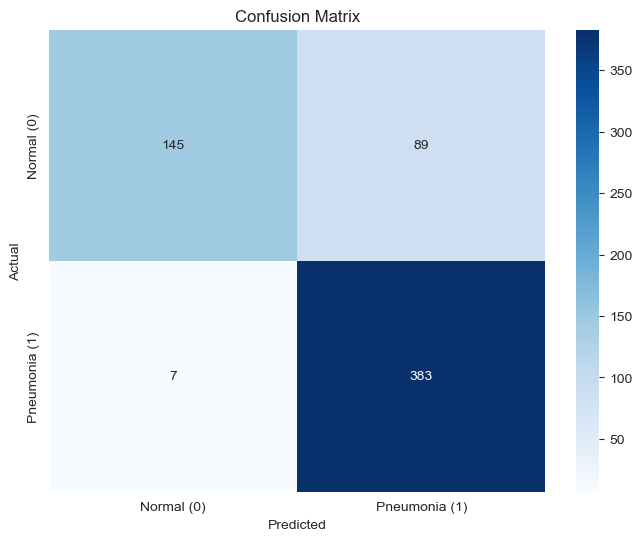

In [853]:
preds_binary = (datasets["test_dataset"]["predictions"] >= best_threshold_test).astype(int)
cm = confusion_matrix(datasets["test_dataset"]["labels"], preds_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal (0)', 'Pneumonia (1)'],
            yticklabels=['Normal (0)', 'Pneumonia (1)'],
            vmax=cm.max(), vmin=cm.min())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Results Analysis

- Since we are dealing with a medical diagnosis problem, we prioritize maximizing the recall score, allowing medical experts to exclude false positive instances.
- We then select a threshold that achieves this goal while maintaining a modest precision value.
- Based on the selected threshold, there is a small proportion of Type II error, reflected in the high recall value.
- Further tuning can be performed to enhance precision without compromising the recall score.